In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# hide warning messages
import warnings
warnings.filterwarnings("ignore")

In [4]:
# better plots
sns.set(rc={'figure.figsize':(12,8)});

In [5]:
directory = os.path.dirname(os.getcwd())
directory

'd:\\github\\AssignmentEconometricsIV'

## Question

The third question consists of an inflation forecasting exercise using a large set of monthly macroeconomic variables and nonlinear models. As in the previous question, the forecasts are based on a rolling-window framework of fixed length of 492 observations, starting in January 1959. Therefore, the forecasts start on January 1990. The last forecasts are for November 2021. More specifically, the rolling window forecasting scheme can be described as follows:

1. Run all in-sample analysis and estimation using data from observation a to observation $a + 492 − 1$.
2. Compute the forecast for observation at position $a + 492$.
3. Set $a = a + 1$ and repeat the two steps above.

In [6]:
# read the data
input_path = f'{directory}\\data\\stacionarized_cpi.csv'
df = pd.read_csv(input_path)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [7]:
df.head()

,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,...,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,INVEST
date,,,,,,,,,,,,,,,,,,,,,
1959-03-01,0.643011,0.735934,0.941009,0.832120,1.430253,0.603609,0.489927,0.000000,1.939697,-0.474508,...,0.000000,0.000000,-0.024978,0.066630,-0.112407,0.026180,-0.002184,-0.814665,0.481883,-1.479236
1959-04-01,0.649412,0.704864,-0.363947,0.061571,2.107741,1.433803,1.454234,1.565338,0.637947,1.651147,...,0.000000,0.000000,0.130473,-0.022927,0.134899,0.175237,-0.002163,1.220345,-0.488953,2.492924
1959-05-01,0.576311,0.661646,1.200535,0.780340,1.495024,0.826920,0.958304,0.476849,2.015117,0.000000,...,0.000000,0.000000,-0.143071,0.064631,-0.168653,-0.193673,-0.002143,-0.408972,-0.481929,-1.534223
1959-06-01,0.310244,0.297379,0.370829,0.906434,0.114438,0.703445,0.712642,-0.476849,0.745195,-0.704372,...,0.325204,0.337268,0.229263,0.032895,0.331580,0.209340,-0.461895,0.399176,0.479617,-1.225183
1959-07-01,-0.058921,-0.076384,-0.342687,-0.033018,-2.423797,0.116693,0.824692,1.305596,1.961284,0.821073,...,-0.001054,-0.001134,-0.074908,-0.152071,-0.123781,-0.010035,0.000000,-0.404015,-0.479617,2.934128


In [8]:
# set the amount of lags
lags = 4

In [9]:
# create lagged variables
for col in df.columns:
    for i in range(lags):
        name_col = col + f"(-{i+1})"
        df[name_col] = df[col].shift(i+1)

In [10]:
# inflation rate ahead
df['CPIAUCSL(+1)'] = df['CPIAUCSL'].shift(-1)

In [11]:
# drop nan rows
df = df.dropna()

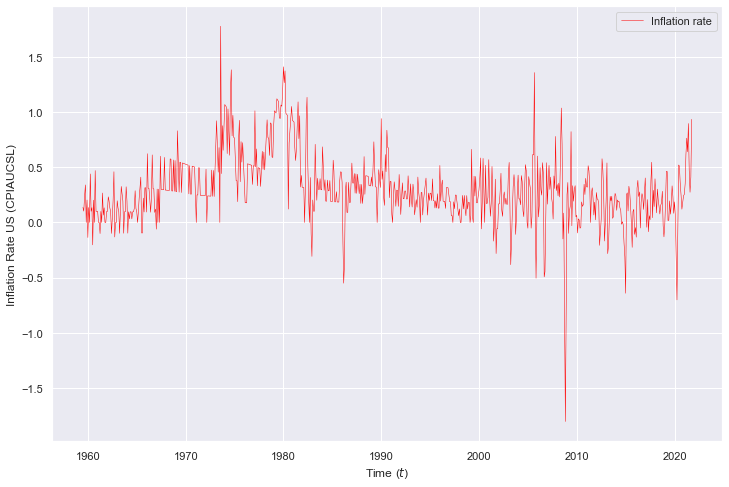

In [12]:
# plot Inflation rate of US
plt.plot(df['CPIAUCSL'], color='red', label='Inflation rate', linewidth = 0.5)

plt.xlabel(f'Time ($t$)')
plt.ylabel('Inflation Rate US (CPIAUCSL)')
plt.legend()
plt.show()

In [13]:
df

,RPI,W875RX1,DPCERA3M086SBEA,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,...,CES2000000008(-4),CES3000000008(-1),CES3000000008(-2),CES3000000008(-3),CES3000000008(-4),INVEST(-1),INVEST(-2),INVEST(-3),INVEST(-4),CPIAUCSL(+1)
date,,,,,,,,,,,,,,,,,,,,,
1959-07-01,-0.058921,-0.076384,-0.342687,-0.033018,-2.423797,0.116693,0.824692,1.305596,1.961284,0.821073,...,-0.814665,0.479617,-0.481929,-0.488953,0.481883,-1.225183,-1.534223,2.492924,-1.479236,0.102810
1959-08-01,-0.563656,-0.574751,0.600333,0.636421,-3.446532,-0.702622,-0.234750,0.117877,-2.831305,1.161607,...,1.220345,-0.479617,0.479617,-0.481929,-0.488953,2.934128,-1.225183,-1.534223,2.492924,0.239316
1959-09-01,0.072136,0.000000,1.001845,-1.315700,-0.120914,-0.470898,-0.353804,-0.353743,-3.041963,0.575782,...,-0.408972,-0.961546,-0.479617,0.479617,-0.481929,-2.549545,2.934128,-1.225183,-1.534223,0.340716
1959-10-01,0.128006,0.115215,-0.683507,0.728802,-0.729019,-0.236695,-0.473264,-0.474023,2.290232,-1.270922,...,0.399176,1.443475,-0.961546,-0.479617,0.479617,1.633290,-2.549545,2.934128,-1.225183,0.000000
1959-11-01,0.759485,0.671571,-0.044618,-2.670393,0.607511,-1.070659,-1.674509,-2.161044,-13.155942,1.385480,...,-0.404015,-0.963857,1.443475,-0.961546,-0.479617,-0.339730,1.633290,-2.549545,2.934128,0.204012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,-0.268168,0.246839,0.588917,0.848804,0.546727,0.002528,0.114008,-0.202956,-1.515281,0.156910,...,-0.303365,0.209887,0.298788,-0.215580,0.041757,0.058641,-0.293195,0.525137,0.009150,0.471599
2021-07-01,0.803329,0.376098,-0.313442,-1.637075,0.767226,1.461057,1.668025,0.970731,4.626890,-0.042815,...,0.773581,-0.004596,0.209887,0.298788,-0.215580,-0.716631,0.058641,-0.293195,0.525137,0.273614
2021-08-01,-0.041013,-0.094940,0.727968,1.152697,-0.136496,-0.232743,-0.485054,-0.407293,-1.633303,-0.062902,...,0.560450,-0.046350,-0.004596,0.209887,0.298788,-0.488861,-0.716631,0.058641,-0.293195,0.410742


In [14]:
from functions.nonlinear_models import NN_forecast, LSTM_forecast

In [15]:
# set variables
y = df["CPIAUCSL(+1)"]
X = df.drop("CPIAUCSL(+1)", axis=1)

In [16]:
# add forecast columns
df["CPIAUCSL_estimated_NN"] = np.nan
df["CPIAUCSL_estimated_LSTM"] = np.nan

### (a) (60 points) 

Estimate a model based on a neural network specification and compute one step ahead forecasts. You are free to choose between shallow, deep, convolution or LSTM networks. However, you have to motivate your particular choice;

feedforward Neural Network model

Cunha Medeiros, Marcelo and Schütte, Erik Christian Montes and Soussi, Tobias Skipper, Global Inflation: Implications for forecasting and monetary policy (June 24, 2022). Available at SSRN: https://ssrn.com/abstract=4145665 or http://dx.doi.org/10.2139/ssrn.4145665

Architecture:
- Optimizer: Adam (https://arxiv.org/abs/1412.6980)
- Layers: 3 (like the previous paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4145665)
- Activation Function: ReLu $f(x)=\max{(x,0)}$
- Neurons: 100, 60 and 30 in the first, second and third layers respectively (based on https://www.sciencedirect.com/science/article/abs/pii/B978008051433850015X)

LSTM Neural Network model works as the same way, with LSTM acting like a neuron.

In [17]:
# set some parameters
rolling_window = 492 - lags
T = len(y) - rolling_window

In [28]:
# list of forecast squared errors
#errors_NN = []
errors_LSTM = []

for t in tqdm(range(T), desc='Processing for time'):
    # predict date
    date = y[[rolling_window+t]].index

    # estimation sets
    X_train = X[t:(rolling_window+t)]
    y_train = y[t:(rolling_window+t)]

    # forecast sets
    X_test = X.iloc[[rolling_window+t]]
    y_test = y[rolling_window+t]
    
    # estimations
    #y_pred_NN, error_pred_NN = NN_forecast(X_train, y_train, X_test, y_test)
    y_pred_LSTM, error_pred_LSTM = LSTM_forecast(X_train, y_train, X_test, y_test)

    # fill forecast columns
    #df["CPIAUCSL_estimated_NN"][date] = y_pred_NN
    df["CPIAUCSL_estimated_LSTM"][date] = y_pred_LSTM

    # append forecast squared errors
    #errors_NN.append(error_pred_NN)
    errors_LSTM.append(error_pred_LSTM)

Processing for time: 100%|██████████| 260/260 [14:31:51<00:00, 201.20s/it]  


In [29]:
df[["CPIAUCSL(+1)", "CPIAUCSL_estimated_NN", "CPIAUCSL_estimated_LSTM"]][rolling_window:]

,CPIAUCSL(+1),CPIAUCSL_estimated_NN,CPIAUCSL_estimated_LSTM
date,,,
2000-03-01,-0.058514,0.242504,0.321759
2000-04-01,0.175234,0.124897,0.129800
2000-05-01,0.580720,0.217302,0.177507
2000-06-01,0.289519,0.527120,0.401178
2000-07-01,0.000000,0.295989,0.225920
...,...,...,...
2021-06-01,0.471599,0.368065,0.353107
2021-07-01,0.273614,-0.373261,0.011361
2021-08-01,0.410742,0.060732,0.363657


In [ ]:
output = f'{directory}\\output\\NN_predictions.csv'
df[["CPIAUCSL", "CPIAUCSL(+1)", "CPIAUCSL_estimated_NN", "CPIAUCSL_estimated_LSTM"]].to_csv(output, sep=',', encoding='utf-8')

In [48]:
path = f'{directory}\\output\\NN_predictions.csv'
df = pd.read_csv(path, index_col=0)
df.index = pd.to_datetime(df.index)

In [58]:
df[rolling_window:]

,CPIAUCSL,CPIAUCSL(+1),CPIAUCSL_estimated_NN,CPIAUCSL_estimated_LSTM
date,,,,
2000-03-01,0.584795,-0.058514,0.242504,0.321759
2000-04-01,-0.058514,0.175234,0.124897,0.129800
2000-05-01,0.175234,0.580720,0.217302,0.177507
2000-06-01,0.580720,0.289519,0.527120,0.401178
2000-07-01,0.289519,0.000000,0.295989,0.225920
...,...,...,...,...
2021-06-01,0.896742,0.471599,0.368065,0.353107
2021-07-01,0.471599,0.273614,-0.373261,0.011361
2021-08-01,0.273614,0.410742,0.060732,0.363657


In [28]:
# prediction 
prediction_dates = list(X.iloc[(rolling_window):].index)

In [31]:
# treat the error list
errors_NN_ = [item[0] for item in errors_NN]
errors_LSTM_ = [item[0] for item in errors_LSTM]

# compute cumulated mse
cum_errors_NN = list(np.cumsum(errors_NN_))
cum_errors_LSTM = list(np.cumsum(errors_LSTM_))

In [34]:
errors = {'Cumulated_MSE_NN': cum_errors_NN, 'Cumulated_MSE_LSTM': cum_errors_LSTM}
mse = pd.DataFrame(errors, index=prediction_dates)

In [35]:
mse

,Cumulated_MSE_NN,Cumulated_MSE_LSTM
2000-03-01,0.090612,0.144607
2000-04-01,0.093146,0.146672
2000-05-01,0.225218,0.309253
2000-06-01,0.281672,0.321720
2000-07-01,0.369282,0.372760
...,...,...
2021-06-01,25.398293,20.114305
2021-07-01,25.816740,20.183083
2021-08-01,25.939247,20.185299
2021-09-01,26.520357,20.742657


In [ ]:
output = f'{directory}\\output\\NN_MSE.csv'
mse.to_csv(output, sep=',', encoding='utf-8')

In [60]:
path = f'{directory}\\output\\NN_MSE.csv'
mse = pd.read_csv(path, index_col=0)
mse.index = pd.to_datetime(mse.index)

In [62]:
mse

,Cumulated_MSE_NN,Cumulated_MSE_LSTM
2000-03-01,0.090612,0.144607
2000-04-01,0.093146,0.146672
2000-05-01,0.225218,0.309252
2000-06-01,0.281672,0.321720
2000-07-01,0.369282,0.372760
...,...,...
2021-06-01,25.398293,20.114305
2021-07-01,25.816740,20.183083
2021-08-01,25.939247,20.185299
2021-09-01,26.520357,20.742657


### (b) (20 points) 

Plot you forecasts against the four linear benchmarks from Question 2. Comment on you results.

In [29]:
path = '../output/forecasts.csv'
forecast_ln = pd.read_csv(path, index_col=0)
prediction_dates.append(pd.to_datetime('2021-11-01'))
forecast_ln.index = prediction_dates

In [53]:
forecast_ln

,forecasts.forecasts_Q2.AR,forecasts.forecasts_Q2.AR_PC,forecasts.forecasts_Q2.Ridge_4lags,forecasts.forecasts_Q2.Ridge,forecasts.forecasts_Q2.LASSO,forecasts.RF_4lags,RF
2000-03-01,0.347137,0.306083,0.358069,0.387128,0.328962,0.288422,0.290947
2000-04-01,0.424690,0.401117,0.359949,0.346312,0.403520,0.412219,0.368169
2000-05-01,0.184807,0.128173,0.357127,-0.051357,0.259268,0.242006,0.207150
2000-06-01,0.250046,0.286717,0.358928,0.389818,0.223432,0.261034,0.334029
2000-07-01,0.416175,0.423749,0.361864,0.384101,0.403163,0.327478,0.396410
...,...,...,...,...,...,...,...
2021-07-01,0.404299,0.519179,0.239185,0.689236,0.484780,0.416900,0.508636
2021-08-01,0.190942,0.086930,0.233436,0.071695,0.216313,0.073618,0.115075
2021-09-01,0.205723,0.207572,0.232049,0.279974,0.210109,0.214556,0.243461
2021-10-01,0.365649,0.260807,0.233505,0.344095,0.321370,0.276380,0.284157


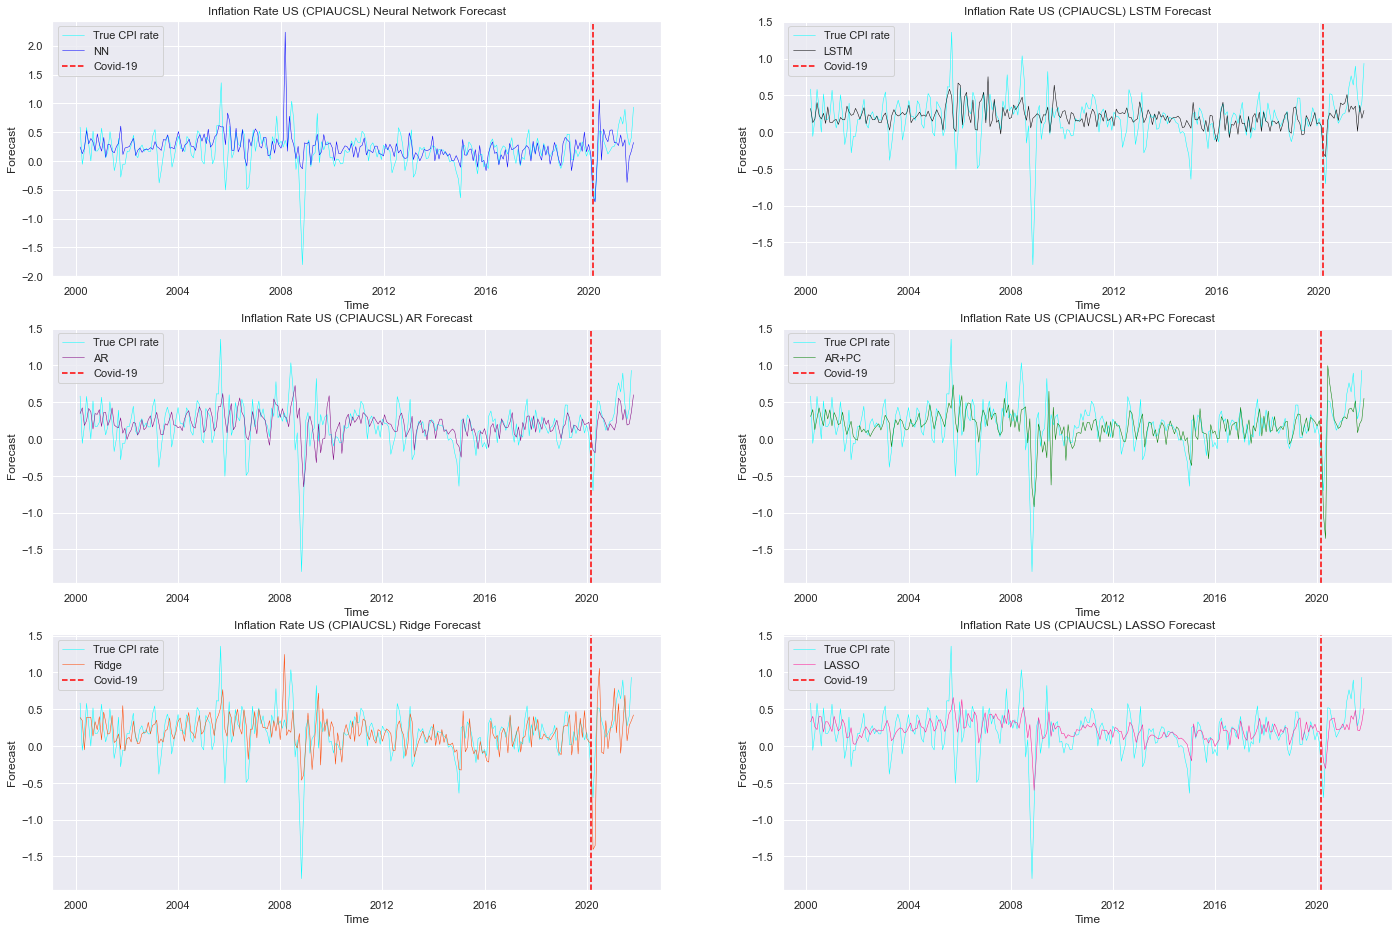

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(24, 16))

# True CPI
axes[0,0].plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth=0.5)
# NN forecasts
axes[0,0].plot(df["CPIAUCSL_estimated_NN"], color='blue', label='NN', linewidth=0.5)
# adding a vertical line at 2020, January
axes[0,0].axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')
# labels
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Forecast')
axes[0,0].set_title('Inflation Rate US (CPIAUCSL) Neural Network Forecast')
axes[0,0].legend()

# True CPI
axes[0,1].plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth=0.5)
# LSTM forecasts
axes[0,1].plot(df["CPIAUCSL_estimated_LSTM"], color='black', label='LSTM', linewidth=0.5)
# adding a vertical line at 2020, January
axes[0,1].axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')
# labels
axes[0,1].set_xlabel('Time')
axes[0,1].set_ylabel('Forecast')
axes[0,1].set_title('Inflation Rate US (CPIAUCSL) LSTM Forecast')
axes[0,1].legend()

# True CPI
axes[1,0].plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth=0.5)
# AR
axes[1,0].plot(forecast_ln["forecasts.forecasts_Q2.AR"], color='purple', label='AR', linewidth=0.5)
# adding a vertical line at 2020, January
axes[1,0].axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')
# labels
axes[1,0].set_xlabel('Time')
axes[1,0].set_ylabel('Forecast')
axes[1,0].set_title('Inflation Rate US (CPIAUCSL) AR Forecast')
axes[1,0].legend()

# True CPI
axes[1,1].plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth=0.5)
# AR+PC
axes[1,1].plot(forecast_ln["forecasts.forecasts_Q2.AR_PC"], color='green', label='AR+PC', linewidth=0.5)
# adding a vertical line at 2020, January
axes[1,1].axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')
# labels
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Forecast')
axes[1,1].set_title('Inflation Rate US (CPIAUCSL) AR+PC Forecast')
axes[1,1].legend()

# True CPI
axes[2,0].plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth=0.5)
# Ridge
axes[2,0].plot(forecast_ln["forecasts.forecasts_Q2.Ridge"], color='orangered', label='Ridge', linewidth=0.5)
# adding a vertical line at 2020, January
axes[2,0].axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')
# labels
axes[2,0].set_xlabel('Time')
axes[2,0].set_ylabel('Forecast')
axes[2,0].set_title('Inflation Rate US (CPIAUCSL) Ridge Forecast')
axes[2,0].legend()

# True CPI
axes[2,1].plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth=0.5)
# LASSO
axes[2,1].plot(forecast_ln["forecasts.forecasts_Q2.LASSO"], color='deeppink', label='LASSO', linewidth=0.5)
# adding a vertical line at 2020, January
axes[2,1].axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')
# labels
axes[2,1].set_xlabel('Time')
axes[2,1].set_ylabel('Forecast')
axes[2,1].set_title('Inflation Rate US (CPIAUCSL) LASSO Forecast')
axes[2,1].legend()

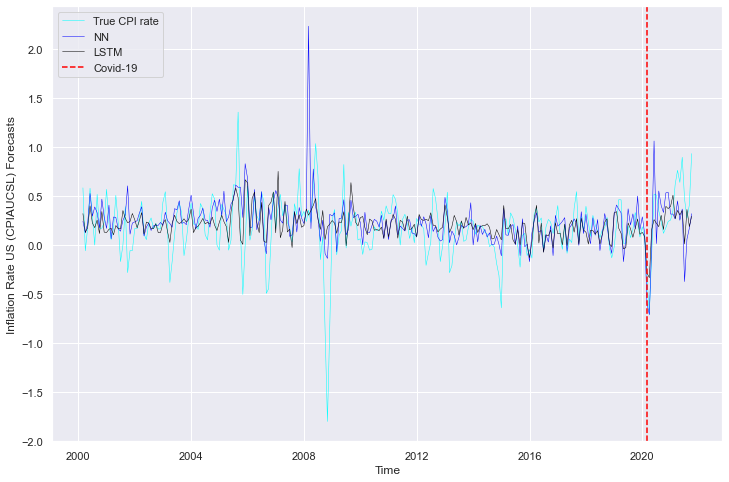

In [65]:
plt.plot(df['CPIAUCSL'][rolling_window:], color='cyan', label='True CPI rate', linewidth = 0.5)

plt.plot(df["CPIAUCSL_estimated_NN"], color='blue', label='NN', linewidth = 0.5)

plt.plot(df["CPIAUCSL_estimated_LSTM"], color='black', label='LSTM', linewidth = 0.5)

# adding a vertical line at 2020, January
plt.axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')

plt.xlabel('Time')
plt.ylabel('Inflation Rate US (CPIAUCSL) Forecasts')
plt.legend()
plt.show()

### (c) (20 points) 

Compute the mean squared error of the NN-based model and the benchmarks. Does the NN model outperform the linear alternative?

In [66]:
path = '../output/cum_error.csv'
cum_mse = pd.read_csv(path, index_col=0)
cum_mse["date"] = pd.to_datetime(cum_mse["date"])
cum_mse.set_index("date", inplace=True)

In [67]:
cum_mse

,AR,AR+PC,Ridge (4 lags),Ridge,LASSO,RF (4 lags),RF
date,,,,,,,
2000-03-01,0.056481,0.077681,0.051405,0.039072,0.065451,0.087837,0.086347
2000-04-01,0.289967,0.288942,0.226516,0.202956,0.278926,0.309426,0.268405
2000-05-01,0.290059,0.291156,0.259602,0.254299,0.285988,0.313885,0.269424
2000-06-01,0.399404,0.377594,0.308793,0.290743,0.413642,0.416084,0.330281
2000-07-01,0.415446,0.395612,0.314027,0.299689,0.426557,0.417525,0.341706
...,...,...,...,...,...,...,...
2021-07-01,20.777157,21.104799,29.034805,21.953238,18.848510,19.511802,18.618540
2021-08-01,20.783992,21.139650,29.036419,21.994010,18.851793,19.551800,18.643675
2021-09-01,20.826024,21.180928,29.068351,22.011110,18.892047,19.590289,18.671658


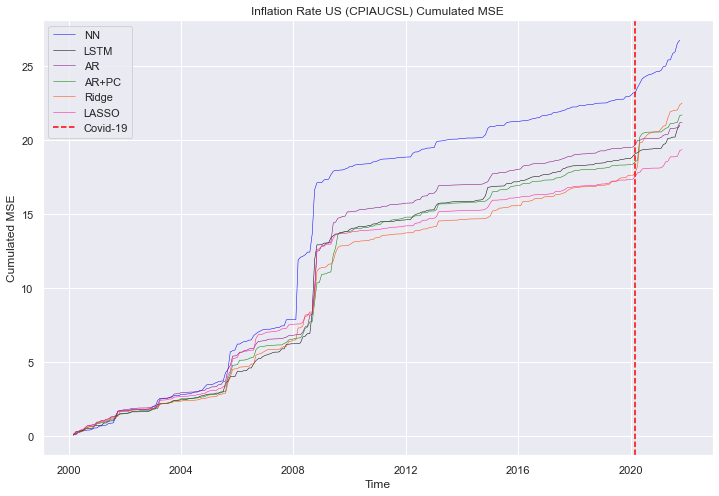

In [68]:
# plot of cumulated MSE
plt.plot(mse["Cumulated_MSE_NN"], color='blue', label="NN", linewidth = 0.5)

# plot of cumulated MSE
plt.plot(mse["Cumulated_MSE_LSTM"], color='black', label="LSTM", linewidth = 0.5)

# plot of cumulated MSE
plt.plot(cum_mse["AR"], color='purple', label="AR", linewidth = 0.5)

# plot of cumulated MSE
plt.plot(cum_mse["AR+PC"], color='green', label="AR+PC", linewidth = 0.5)

# plot of cumulated MSE
plt.plot(cum_mse["Ridge"], color='orangered', label="Ridge", linewidth = 0.5)

# plot of cumulated MSE
plt.plot(cum_mse["LASSO"], color='deeppink', label="LASSO", linewidth = 0.5)

# adding a vertical line at 2020, January
plt.axvline(x=mse.index[240], color='red', linestyle='--', label='Covid-19')

plt.xlabel('Time')
plt.ylabel('Cumulated MSE')
plt.title('Inflation Rate US (CPIAUCSL) Cumulated MSE')
plt.legend()
plt.show()